In [143]:
import json

import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import rasterio as rio
import rioxarray as rx
import xarray as xr

How to change workflow:
* one function to create x array with slope and aspect elev, lc as a single xarray
* second function insret the dem to calculate the Hs to SWE 
* dask to speed up the Hs to SWE process 

In [2]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'OR'

In [3]:
#CSO data path
CSOpath = 'cso-data.geojson'

#path to CSO domain
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# CSO projection
stn_proj = domains[domain]['stn_proj']

# CSO projection
mod_proj = domains[domain]['mod_proj']

In [4]:
#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("http://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [5]:
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285
...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182


# DEM

570400.0 4832800.0 652500.0 4955900.0


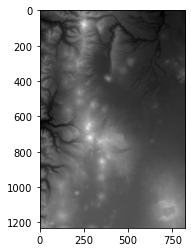

In [14]:
# dem path
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
# DEM data
src = rio.open(dem_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
elevation = src.read(1)

print(minx,miny,maxx,maxy)
#plot
x = plt.imshow(src.read(1), cmap='gray')
plt.show()

In [15]:
#dem resolution
clX,clY = src.res
print(clX,clY)

100.0 100.0


In [18]:
new=CSO_gdf.to_crs(mod_proj)
new.head()

,geometry,id,author,depth,source,timestamp,elevation
0,POINT (589011.969 4917134.109),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647
1,POINT (606516.821 4879579.232),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006
2,POINT (608833.056 4873347.222),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846
3,POINT (605401.306 4873501.781),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476
4,POINT (589006.439 4917132.330),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285


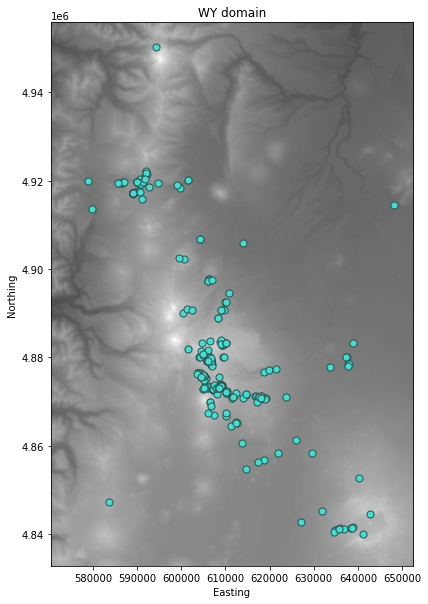

In [19]:
# plot georeferenced SnowModel output with SNOTEL stations 
fig, ax = plt.subplots(1,figsize=(8,10))

#hillshade and elevation
#ax.imshow(np.flipud(hillshade), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray')
ax.imshow(np.flipud(elevation), origin = [minx,miny], extent = [minx,maxx,miny,maxy],cmap ='gray', alpha = 0.7)

ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# title
plt.title('WY domain')

#stations
new.plot(ax=ax,markersize=50, color='turquoise', edgecolor = 'darkslategrey')

#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,1))


#plt.savefig(f"/nfs/attic/dfh/Aragon2/Notebooks/calibration_python/figs/test.png")#Python_Animation_02_frame_{i:04}.png")
plt.show()

In [20]:
#build list of coordinates from point geodataframe
xy = list(map(list, zip(new.geometry.x,new.geometry.y)))

In [21]:
#sample dem
with rio.open(dem_path) as src:
    CSO_gdf['dem_elev'] = [sample[0] for sample in src.sample(xy)]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736
...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261


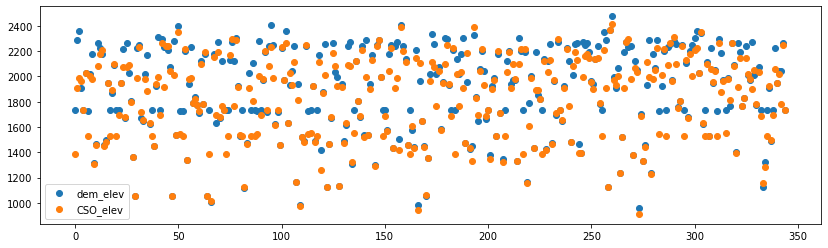

In [35]:
fig, ax = plt.subplots(1,figsize=(14,4))
ax.scatter(CSO_gdf.index.values,CSO_gdf.dem_elev,label='dem_elev')
ax.scatter(CSO_gdf.index.values,CSO_gdf.elevation,label='CSO_elev')
ax.legend()

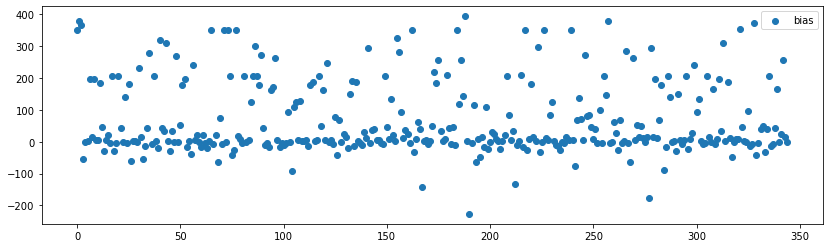

In [36]:
elev_bias = CSO_gdf.dem_elev-CSO_gdf.elevation
fig, ax = plt.subplots(1,figsize=(14,4))
ax.scatter(CSO_gdf.index.values,elev_bias,label='bias')
ax.legend()

elevation categories 

# Slope

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


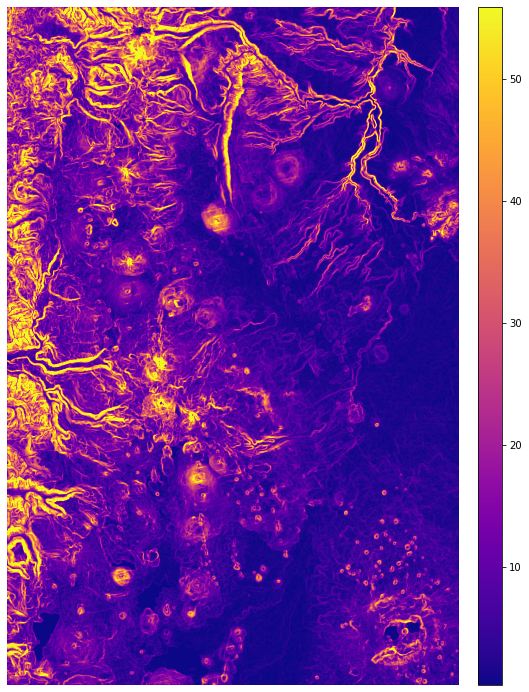

{'vmin': 0.3952847123146057, 'vmax': 55.84605026245117}

In [61]:
import richdem as rd
from osgeo import gdal
ds = gdal.Open(dem_path)
data = np.array(ds.GetRasterBand(1).ReadAsArray())
rda = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(rda, attrib='slope_riserun')
rd.rdShow(sl, axes=False, cmap='plasma', figsize=(8,10))

In [62]:
CSO_gdf['slope'] = slope[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,slope_rd
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,18.238867
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,24.351591
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,10.525268
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,16.250000
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,18.238867
...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,4.756575
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,26.024628
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,31.856121
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,21.039398


# Aspect

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


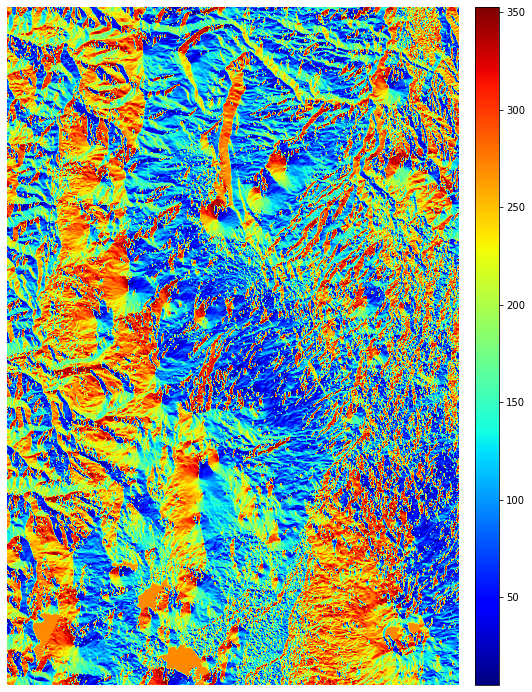

{'vmin': 5.19442892074585, 'vmax': 352.4761657714844}

In [127]:
rda = rd.rdarray(data, no_data=-9999)
aspect = rd.TerrainAttribute(rda, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8,10))

In [128]:
#0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW, 8=flat
DIR=aspect
DIR[(DIR>=0) & (DIR<=22.5)]=0
DIR[(DIR>22.5) & (DIR<=67.5)]=1
DIR[(DIR>67.5) & (DIR<=112.5)]=2
DIR[(DIR>112.5) & (DIR<=157.5)]=3
DIR[(DIR>157.5) & (DIR<=202.5)]=4
DIR[(DIR>202.5) & (DIR<=247.5)]=5
DIR[(DIR>247.5) & (DIR<=292.5)]=6
DIR[(DIR>292.5) & (DIR<=337.5)]=7
DIR[(DIR>337.5) & (DIR<=360)]=0
DIR[slope < 0.5]=8
DIR.astype(int)


rdarray([[7, 6, 6, ..., 3, 2, 3],
         [5, 6, 6, ..., 3, 3, 3],
         [5, 6, 6, ..., 3, 2, 2],
         ...,
         [6, 6, 6, ..., 3, 2, 2],
         [4, 5, 6, ..., 3, 3, 3],
         [5, 5, 6, ..., 2, 2, 3]])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5]


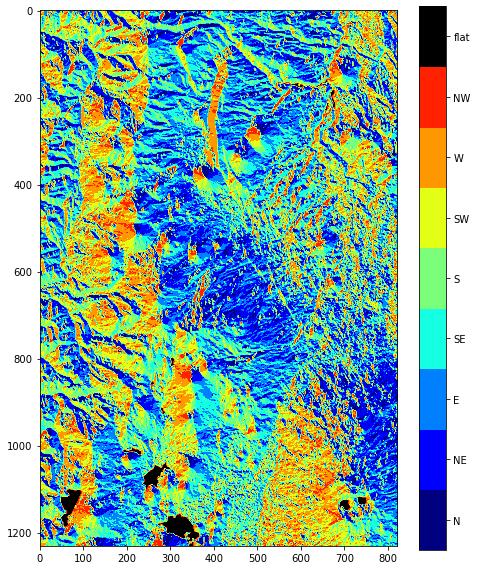

In [129]:
import matplotlib
from matplotlib.colors import ListedColormap

#select colormap
cmap = plt.get_cmap('jet', 9)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:cmap(0), 1:cmap(1), 2:cmap(2), 3:cmap(3), 
          4:cmap(4), 5:cmap(5), 6:cmap(6), 7:cmap(7),8:'black'}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW','flat'])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
#fig.savefig("aspect.png")
plt.show()

In [70]:
CSO_gdf['aspect'] = DIR[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,slope_rd,aspect
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,18.238867,2.0
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,24.351591,4.0
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,10.525268,0.0
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,16.250000,0.0
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,18.238867,2.0
...,...,...,...,...,...,...,...,...,...,...,...
340,POINT (-121.27796 43.71257),ZGXIxK1Z,Bart Wills,81.28,MountainHub,2019-01-25T20:34:05.120Z,1946.420166,1945,4.756575,4.756575,0.0
341,POINT (-121.68917 44.00308),Zkrpj1cA,Aaron Hartz,115.00,MountainHub,2019-01-09T21:40:29.582Z,2015.768555,2040,26.024628,26.024628,7.0
342,POINT (-121.69607 44.02647),ZL/qU18O,Aaron Hartz,120.00,MountainHub,2018-01-19T19:32:57.136Z,1785.061646,2043,31.856121,31.856121,5.0
343,POINT (-121.64619 44.00297),ZLvKCpiv,Bart Wills,86.36,MountainHub,2018-12-01T16:21:02.048Z,2246.336182,2261,21.039398,21.039398,5.0


# Landcover

### Snowmodel LC Codes

|Code  |Landcover Class |Code  |Landcover Class |
| --- | --- | --- | --- |
|1     | coniferous forest |13    | subalpine meadow  |      
|2     | deciduous forest |14    | tundra (non-tussock) |      
|3     | mixed forest |15    | tundra (tussock) |           
|4     | scattered short-conifer |16    | prostrate shrub tundra | 
|5     | clearcut conifer |17    | arctic gram. wetland |       
|6     | mesic upland shrub |18    | bare |       
|7     | xeric upland shrub |19    | water/possibly frozen |       
|8     | playa shrubland |20    | permanent snow/glacier |         
|9     | shrub wetland/riparian |21    | residential/urban |   
|10    | erect shrub tundra |22    | tall crops |       
|11    | low shrub tundra |23    | short crops |        
|12    | grassland rangeland  |24    | ocean |    
      

[ 0.5  1.5  2.5  6.5  9.5 12.5 18.5 20.5 21.5 22.5 23.5 24.5]


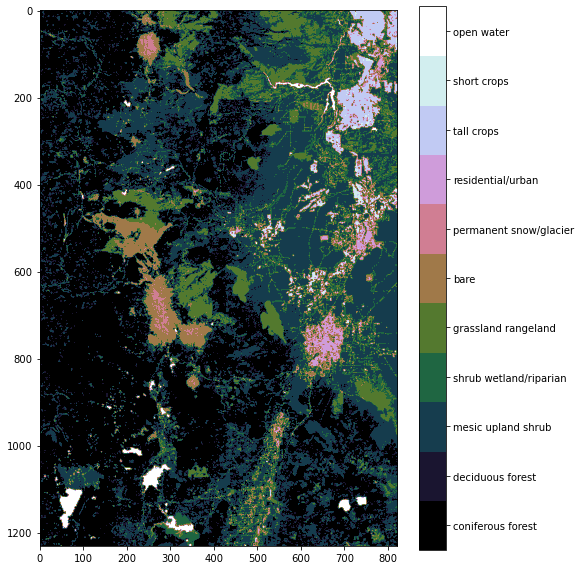

In [125]:
# dem path
lc_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/NLCD2016_'+domain+'.tif'


# DEM data
src = rio.open(lc_path)
bound = src.bounds
minx = bound[0]
miny = bound[1]
maxx = bound[2]
maxy = bound[3]

#with rio.open(dtm) as src:
lc = src.read(1)

# #reassign lc from NLCD to SM classes
DIR=DIR=np.empty([np.shape(lc)[0],np.shape(lc)[1]])
DIR[lc == 11 ]=24
DIR[lc == 12 ]=20
DIR[lc == 21 ]=21
DIR[lc == 22 ]=21
DIR[lc == 23 ]=21
DIR[lc == 24 ]=21
DIR[lc == 31 ]=18
DIR[lc == 41 ]=2
DIR[lc == 42 ]=1
DIR[lc == 43 ]=6
DIR[lc == 51 ]=6
DIR[lc == 52 ]=6
DIR[lc == 71 ]=12
DIR[lc == 72 ]=12
DIR[lc == 73 ]=12
DIR[lc == 74 ]=12
DIR[lc == 81 ]=23
DIR[lc == 82 ]=22
DIR[lc == 90 ]=9
DIR[lc == 95 ]=9
DIR.astype(int)

#plot
#select colormap
cmap = plt.get_cmap('cubehelix',11)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
#nlcd
# col_dict={11:'cyan', 12:cmap(1), 21:cmap(2), 22:cmap(3), 23:cmap(4), 
#           24:cmap(5), 31:cmap(6), 41:cmap(7), 42:cmap(8), 43:cmap(9), 
#           52:cmap(10), 71:cmap(11), 81:cmap(12), 82:cmap(13), 90:cmap(14),95:cmap(15)}
#sm
col_dict={1:cmap(0), 2:cmap(1), 6:cmap(2), 9:cmap(3), 12:cmap(4), 
          18:cmap(5), 20:cmap(6), 21:cmap(7), 22:cmap(8), 23:cmap(9), 24:cmap(10)}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category
#nlcd
# labels = np.array(['11', '12', '21', '22', '23', '24', '31', '41',
#                    '42', '43', '52', '71', '81', '82', '90', '95'])
# #sm nums
# labels = np.array(['1', '2', '6', '9', '12', '18', '20', '21',
#                    '22', '23','24'])
#sm names
labels = np.array(['coniferous forest', 'deciduous forest', 'mesic upland shrub', 'shrub wetland/riparian', 
                   'grassland rangeland', 'bare', 'permanent snow/glacier', 'residential/urban',
                   'tall crops', 'short crops','open water'])

len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
#fig.savefig("lc.png")
plt.show()

# fig, ax = plt.subplots(1,figsize=(8,10))
# im = ax.imshow(src.read(1), cmap='Set3')
# cb = fig.colorbar(im)

In [118]:
#sample lc
CSO_gdf['lc'] = DIR[rows,cols]
CSO_gdf

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,aspect,lc
0,POINT (-110.77481 43.69544),02DdpYBd,Lisa Van Sciver,135.0,SnowPilot,2019-03-01T18:00:00.000Z,2560.966553,2553,22.078302,3.0,52.0
1,POINT (-110.56087 43.63153),0Lk5ZXTG,Luke LeMaire,74.0,SnowPilot,2020-02-17T22:30:00.000Z,2529.348389,2113,12.137064,4.0,42.0
2,POINT (-110.60593 43.66678),0MdWYWBa,Leanne,60.0,MountainHub,2019-04-16T16:05:38.177Z,2113.166748,2111,1.542363,5.0,52.0
3,POINT (-110.95347 43.50014),0O7JDkYH,Allen OBannon,105.0,MountainHub,2018-02-11T16:26:06.143Z,2650.888672,2658,19.632394,5.0,42.0
4,POINT (-110.99969 43.49204),0onwcZNu,David Staley,100.0,SnowPilot,2017-12-27T01:05:22.000Z,2503.708252,2517,25.931859,2.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...
572,POINT (-111.14069 43.37176),ZoelXlRb,Chris McCollister,132.0,SnowPilot,2018-02-23T23:08:22.000Z,2607.050293,2786,20.273796,1.0,42.0
573,POINT (-110.37463 43.80428),zqSBg0OG,JD,68.0,MountainHub,2020-01-24T21:08:26.319Z,2331.153076,2323,4.653281,7.0,42.0
574,POINT (-110.58513 43.66956),Z+ReFtUG,Jackson Ray,78.0,MountainHub,2019-04-16T16:11:25.697Z,2219.418945,2205,11.340875,6.0,52.0
575,POINT (-110.15553 44.46178),ZsTR7G2t,John McCurdy,165.0,SnowPilot,2016-12-23T17:46:29.000Z,2770.274658,2833,16.742978,0.0,71.0


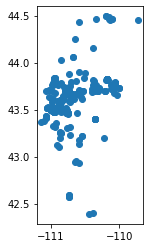

In [12]:
CSO_gdf.plot()

In [132]:

CSO_gdf['dt'] = pd.to_datetime(CSO_gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')

In [133]:
CSO_gdf['Y'] = pd.DatetimeIndex(CSO_gdf['dt']).year
CSO_gdf['M'] = pd.DatetimeIndex(CSO_gdf['dt']).month
CSO_gdf['D'] = pd.DatetimeIndex(CSO_gdf['dt']).day
CSO_gdf["LON"] = CSO_gdf.geometry.x
CSO_gdf["LAT"] = CSO_gdf.geometry.y
#convert snow depth to m
CSO_gdf['H'] = CSO_gdf.depth/100
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,slope_rd,aspect,dt,Y,M,D,LON,LAT,H
0,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,18.238867,2.0,2018-01-08 18:57:59.953000+00:00,2018,1,8,-121.882193,44.402026,0.4826
1,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,24.351591,4.0,2018-01-29 21:40:54.593000+00:00,2018,1,29,-121.670058,44.061643,2.0500
2,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,10.525268,0.0,2018-01-24 22:33:32+00:00,2018,1,24,-121.642427,44.005209,2.4000
3,POINT (-121.68519 44.00710),0sZZdUlx,Bart Wills,63.50,MountainHub,2019-12-28T17:11:13.868Z,1964.787476,1910,16.250000,16.250000,0.0,2019-12-28 17:11:13.868000+00:00,2019,12,28,-121.685192,44.007101,0.6350
4,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,18.238867,2.0,2018-05-01 20:43:22.391000+00:00,2018,5,1,-121.882263,44.402010,1.3208


In [134]:
print('Total number of CSO in daimain = ',len(CSO_gdf))

Total number of CSO in daimain =  345


In [135]:
CSO_gdf = CSO_gdf.set_index(['dt'])
print('Total number of CSO in daimain within time bounds = ',len(CSO_gdf.loc[st:ed]))

Total number of CSO in daimain within time bounds =  276


In [136]:
CSO_gdf = CSO_gdf.loc[st:ed]
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,dem_elev,slope,slope_rd,aspect,Y,M,D,LON,LAT,H
dt,,,,,,,,,,,,,,,,,
2018-01-08 18:57:59.953000+00:00,POINT (-121.88219 44.40203),0Dx1m0fR,David Hill,48.26,MountainHub,2018-01-08T18:57:59.953Z,1386.363647,1736,18.238867,18.238867,2.0,2018,1,8,-121.882193,44.402026,0.4826
2018-01-29 21:40:54.593000+00:00,POINT (-121.67006 44.06164),0mwYxBxA,Aaron Hartz,205.00,MountainHub,2018-01-29T21:40:54.593Z,1910.531006,2291,24.351591,24.351591,4.0,2018,1,29,-121.670058,44.061643,2.0500
2018-01-24 22:33:32+00:00,POINT (-121.64243 44.00521),0p9O570Q,Philip Bowker,240.00,SnowPilot,2018-01-24T22:33:32.000Z,1990.766846,2358,10.525268,10.525268,0.0,2018,1,24,-121.642427,44.005209,2.4000
2018-05-01 20:43:22.391000+00:00,POINT (-121.88226 44.40201),0tVAyhys,David Hill,132.08,MountainHub,2018-05-01T20:43:22.391Z,1736.092285,1736,18.238867,18.238867,2.0,2018,5,1,-121.882263,44.402010,1.3208
2019-02-15 21:32:27.733000+00:00,POINT (-121.69590 44.02604),0TYTP3bw,Aaron Hartz,270.00,MountainHub,2019-02-15T21:32:27.733Z,2027.807373,2029,18.279942,18.279942,3.0,2019,2,15,-121.695898,44.026042,2.7000


# Hs to SWE

In [155]:
test=xr.DataArray(da)
test

<xarray.DataArray (band: 1, y: 1231, x: 821)>
array([[[42, 42, 42, ..., 82, 82, 82],
        [42, 42, 42, ..., 82, 82, 82],
        [42, 42, 42, ..., 82, 82, 82],
        ...,
        [42, 42, 52, ..., 42, 42, 42],
        [42, 42, 42, ..., 42, 42, 42],
        [42, 42, 42, ..., 42, 42, 42]]], dtype=int16)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 4.956e+06 4.956e+06 ... 4.833e+06 4.833e+06
  * x            (x) float64 5.704e+05 5.706e+05 ... 6.524e+05 6.524e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     elevation
    grid_mapping:  spatial_ref

In [156]:
test['lc'] = (('y', 'x'), lc)
test

<xarray.DataArray (band: 1, y: 1231, x: 821)>
array([[[42, 42, 42, ..., 82, 82, 82],
        [42, 42, 42, ..., 82, 82, 82],
        [42, 42, 42, ..., 82, 82, 82],
        ...,
        [42, 42, 52, ..., 42, 42, 42],
        [42, 42, 42, ..., 42, 42, 42],
        [42, 42, 42, ..., 42, 42, 42]]], dtype=int16)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 4.956e+06 4.956e+06 ... 4.833e+06 4.833e+06
  * x            (x) float64 5.704e+05 5.706e+05 ... 6.524e+05 6.524e+05
    spatial_ref  int64 0
    lc           (y, x) float64 42.0 42.0 42.0 42.0 42.0 ... 42.0 42.0 42.0 42.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     elevation
    grid_mapping:  spatial_ref

In [162]:
np.shape(test.band)

(1,)

In [145]:
xr.DataArray(lc)

<xarray.DataArray (dim_0: 1231, dim_1: 821)>
array([[42., 42., 42., ..., 82., 82., 82.],
       [42., 42., 42., ..., 82., 82., 82.],
       [42., 42., 42., ..., 82., 82., 82.],
       ...,
       [42., 42., 52., ..., 42., 42., 42.],
       [42., 42., 42., ..., 42., 42., 42.],
       [42., 42., 42., ..., 42., 42., 42.]])
Dimensions without coordinates: dim_0, dim_1

In [139]:
# dem path - xarray
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
da = rx.open_rasterio(dem_path)
da

<xarray.DataArray (band: 1, y: 1231, x: 821)>
[1010651 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 4.956e+06 4.956e+06 ... 4.833e+06 4.833e+06
  * x            (x) float64 5.704e+05 5.706e+05 ... 6.524e+05 6.524e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     elevation
    grid_mapping:  spatial_ref

In [ ]:
# Compute the lon/lat coordinates with rasterio.warp.transform
ny, nx = len(da['y']), len(da['x'])
x, y = np.meshgrid(da['x'], da['y'])

# Rasterio works with 1D arrays
lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                     x.flatten(), y.flatten())
lon = np.asarray(lon).reshape((ny, nx))
lat = np.asarray(lat).reshape((ny, nx))
da.coords['lon'] = (('y', 'x'), lon)
da.coords['lat'] = (('y', 'x'), lat)

In [137]:
from Depth2SWE import swe_calc

In [ ]:
# incorporate dask??

In [ ]:
import numpy as np
from osgeo import gdal
from scipy.interpolate import interp2d
from datetime import date

def swe_calc(Y,M,D,H,LAT,LON):
    #Build lat/lon array 
    ncols = 7300
    nrows = 2839
    xll = -168.00051894775
    yll = 30.002598288104
    clsz = 0.014795907586
    #Longitudes
    ln = np.arange(xll, xll+ncols*clsz, clsz)
    #Latitudes
    lt = np.arange(yll, yll+nrows*clsz, clsz)
    la = np.flipud(lt)

    #Import temperature difference data
    geo = gdal.Open('td_final.txt')
    td = geo.ReadAsArray()
    #Import winter precipitation data
    geo = gdal.Open('ppt_wt_final.txt')
    pptwt = geo.ReadAsArray()

    def calc(Y,M,D,H,LAT,LON):
        #Interpolate temp to input
        f_td = interp2d(ln, la, td, kind='cubic')
        TD = f_td(LON, LAT)
        #Interpolate temp to input
        f_ppt = interp2d(ln, la, pptwt, kind='cubic')
        PPTWT = f_ppt(LON, LAT)
        #Determine day of year
        DOY = date.toordinal(date(Y,M,D))-date.toordinal(date(Y,9,30))
        if DOY < 0:
            DOY = DOY+365
        #Apply regression equation 
        a = [0.0533,0.948,0.1701,-0.1314,0.2922] #accumulation phase
        b = [0.0481,1.0395,0.1699,-0.0461,0.1804]; #ablation phase
        SWE = a[0]*H**a[1]*PPTWT**a[2]*TD**a[3]*DOY**a[4]*(-np.tanh(.01*\
            (DOY-180))+1)/2 + b[0]*H**b[1]*PPTWT**b[2]*TD**b[3]*DOY**b[4]*\
            (np.tanh(.01*(DOY-180))+1)/2;
        return SWE,DOY

    #Create output arrays 
    SWE = np.zeros(len(H))*np.nan
    DOY = np.zeros(len(H))*np.nan
    for i in np.arange(len(H)):
        swe, doy = calc(Y[i],M[i],D[i],H[i],LAT[i],LON[i])
        SWE[i] = swe
        DOY[i] = int(doy)
    return SWE, DOY

In [138]:
SWE,DOY = swe_calc(CSO_gdf.Y.values,CSO_gdf.M.values,CSO_gdf.D.values,
                   CSO_gdf.H.values,CSO_gdf.LAT.values,CSO_gdf.LON.values)

KeyboardInterrupt: 

In [ ]:
CSO_gdf['SWE'] = SWE
CSO_gdf['DOY'] = DOY
CSO_gdf.head()

## QC observations 

* 

## Organize data by various methods

* Aspect
* Elevation
* Timing
* Look up ideal temporal spatial analysis 
* Landcover class

vs random sampling 

# need to develop a way to QC the CSO data and create assimilation ensebles 

In [ ]:
# print as file for SM

In [19]:
import Depth2SWE

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

In [22]:
#print out SM input
#Print out .dat file 
#https://pyformat.info/
f= open(outFpath,"w+")
for z in range(count.shape[0]):
    f.write('{:08.0f}\t'.format(count[z])+'{:10.0f}\t'.format(est_idx[z])+'{:10.0f}\t'.format(nor_idx[z])+
            '{:10.0f}\t'.format(stn_est[z])+'{:10.0f}\t\n'.format(stn_nor[z]))
f.close() 

NameError: name 'outFpath' is not defined

# Extra

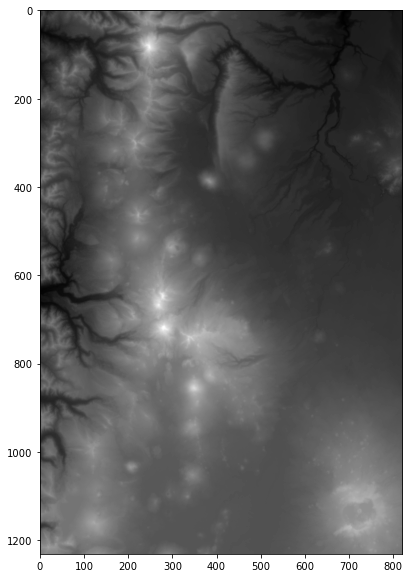

In [10]:
# dem path - xarray
dem_path = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/DEM_'+domain+'.tif'
da = rx.open_rasterio(dem_path)
fig, ax = plt.subplots(1,figsize=(8,10))
x = ax.imshow(np.squeeze(da), cmap='gray')

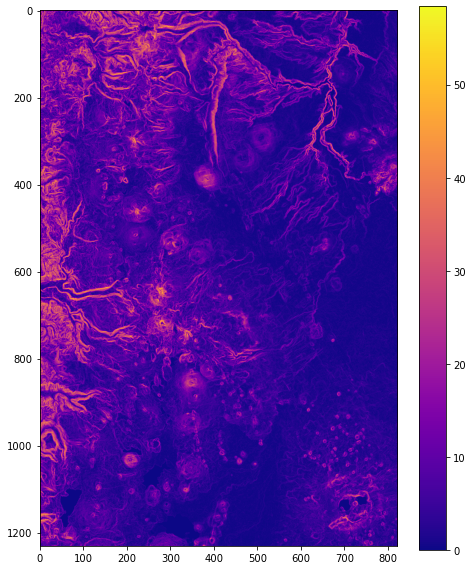

In [51]:
#slope
dx, dy = np.gradient(elevation, clX)
slope = 180/np.pi*np.arctan(np.sqrt(dx**2 + dy**2))
with rio.open(dem_path) as src:
    rows, cols = rio.transform.rowcol(src.transform, new.geometry.centroid.x, new.geometry.centroid.y)
CSO_gdf['slope'] = slope[rows,cols]

# plot slope
fig, ax = plt.subplots(1,figsize=(8,10))

im = ax.imshow(slope,cmap ='plasma')

cbar = fig.colorbar(im)

In [ ]:
#aspect trials

In [101]:
dx, dy = np.gradient(elevation, clX)

In [102]:
#shean
aspect = np.arctan2(-dx, dy)
aspect = np.degrees(aspect)

In [103]:
#0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW
DIR=aspect
DIR[(DIR>=0) & (DIR<=22.5)]=0
DIR[(DIR>22.5) & (DIR<=67.5)]=1
DIR[(DIR>67.5) & (DIR<=112.5)]=2
DIR[(DIR>112.5) & (DIR<=157.5)]=3
DIR[(DIR>157.5) & (DIR<=180)]=4

DIR[(DIR<0) & (DIR>=-22.5)]=0
DIR[(DIR<-22.5) & (DIR>=-67.5)]=7
DIR[(DIR<-67.5) & (DIR>=-112.5)]=6
DIR[(DIR<-112.5) & (DIR>=-157.5)]=5
DIR[(DIR<-157.5) & (DIR>=-180)]=4

DIR.astype(int)

array([[0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 2, 1, 1],
       [7, 0, 0, ..., 2, 0, 1],
       ...,
       [2, 2, 2, ..., 1, 1, 7],
       [2, 2, 1, ..., 1, 0, 0],
       [2, 1, 0, ..., 0, 0, 0]])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5]


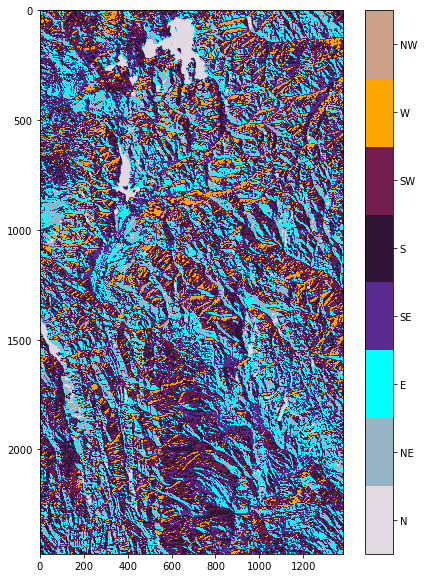

In [104]:
import matplotlib
from matplotlib.colors import ListedColormap

# Let's design a dummy land use field
A = np.reshape([7,2,13,7,2,2], (2,3))
vals = np.unique(A)

#select colormap
cmap = plt.get_cmap('twilight', 9)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:cmap(0), 1:cmap(1), 2:'cyan', 3:cmap(3), 
          4:cmap(4), 5:cmap(5), 6:'orange', 7:cmap(7)}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
fig.savefig("example_landuse.png")
plt.show()

In [109]:
#hill
aspect = 180/np.pi*np.arctan2(dy, dx)
aspect[aspect >=180]=(aspect[aspect >=180]-180)
aspect[aspect < 180]=(aspect[aspect < 180]+180)
aspect

array([[270.        , 264.14398641, 283.49573328, ..., 337.89055166,
        288.85315876, 291.37062227],
       [255.25643716, 268.40885973, 281.76828893, ..., 344.57783868,
        296.56505118, 302.73522627],
       [240.64224646, 265.23635831, 270.        , ..., 342.34987578,
        291.57130719, 297.69947281],
       ...,
       [ 10.30484647, 354.40066066, 342.71850163, ..., 296.56505118,
        296.56505118, 233.13010235],
       [ 18.6989828 , 356.42366563, 306.02737339, ..., 303.69006753,
        285.9453959 , 264.28940686],
       [  2.48955292, 328.13402231, 276.61346048, ..., 270.        ,
        270.        , 270.        ]])

In [110]:
#0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW
DIR=aspect
DIR[(DIR>=0) & (DIR<=22.5)]=0
DIR[(DIR>22.5) & (DIR<=67.5)]=1
DIR[(DIR>67.5) & (DIR<=112.5)]=2
DIR[(DIR>112.5) & (DIR<=157.5)]=3
DIR[(DIR>157.5) & (DIR<=202.5)]=4
DIR[(DIR>202.5) & (DIR<=247.5)]=5
DIR[(DIR>247.5) & (DIR<=292.5)]=6
DIR[(DIR>292.5) & (DIR<=337.5)]=7
DIR[(DIR>337.5) & (DIR<=360)]=0
#DIR[slope == 0]='flat'
DIR.astype(int)


array([[6, 6, 6, ..., 0, 6, 6],
       [6, 6, 6, ..., 0, 7, 7],
       [5, 6, 6, ..., 0, 6, 7],
       ...,
       [0, 0, 0, ..., 7, 7, 5],
       [0, 0, 7, ..., 7, 6, 6],
       [0, 7, 6, ..., 6, 6, 6]])

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5]


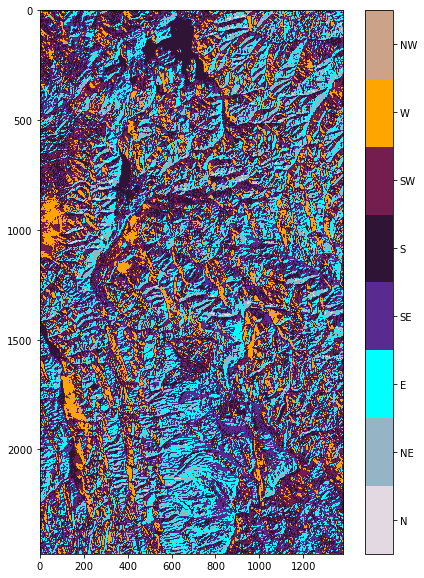

In [111]:
import matplotlib
from matplotlib.colors import ListedColormap

# Let's design a dummy land use field
A = np.reshape([7,2,13,7,2,2], (2,3))
vals = np.unique(A)

#select colormap
cmap = plt.get_cmap('twilight', 9)

# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:cmap(0), 1:cmap(1), 2:'cyan', 3:cmap(3), 
          4:cmap(4), 5:cmap(5), 6:'orange', 7:cmap(7)}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

# Plot our figure
fig,ax = plt.subplots(1,figsize=(8,10))
im = ax.imshow(DIR, cmap=cm, norm=norm)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
fig.savefig("example_landuse.png")
plt.show()

In [135]:
#richdem
aspect = 180/np.pi*np.arctan2(dy, -dx)
aspect[aspect <=90]=(90-aspect[aspect <=90])
aspect[aspect > 90]=(360-aspect[aspect > 90]+90)
aspect

array([[270.        , 275.85601359, 193.49573328, ..., 247.89055166,
        198.85315876, 201.37062227],
       [284.74356284, 271.59114027, 191.76828893, ..., 254.57783868,
        206.56505118, 212.73522627],
       [299.35775354, 274.76364169, 270.        , ..., 252.34987578,
        201.57130719, 207.69947281],
       ...,
       [280.30484647, 264.40066066, 252.71850163, ..., 206.56505118,
        206.56505118, 306.86989765],
       [288.6989828 , 266.42366563, 216.02737339, ..., 213.69006753,
        195.9453959 , 275.71059314],
       [272.48955292, 238.13402231, 186.61346048, ..., 270.        ,
        270.        , 270.        ]])

In [96]:
aspect = 180/np.pi*np.arctan2(-dy, dx)
aspect[aspect < 0]=(360+aspect[aspect < 0])
aspect

array([[ 33.69006753,  21.80140949, 315.        ],
       [345.96375653, 341.56505118, 333.43494882],
       [315.        , 315.        , 323.13010235]])

In [158]:
aspect= 180 - np.arctan(dy/dx)+90*(dx/np.abs(dy))
from numpy import inf
aspect[aspect == -inf] = 0
aspect[aspect == inf] = 0
aspect

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[   0.        , 1057.39779328,  555.23554498, ...,  217.74741366,
         443.90047827,  410.37298772],
       [ 521.74267629, 3419.97222936,  612.20539539, ...,  206.12921504,
         360.46364761,  320.57133748],
       [ 339.48761054, 1259.91685877,    0.        , ...,  209.89910718,
         408.02354916,  351.91201843],
       ...,
       [ 162.24542081,  190.29659883,  209.26917728, ...,  360.46364761,
         360.46364761,  299.35649889],
       [ 148.29402403,  187.13337752,  304.37879629, ...,  315.5880026 ,
         495.27829966, 1079.90033135],
       [ 174.55961109,  236.96057604,  956.36542666, ...,    0.        ,
           0.        ,    0.        ]])